Daniela Jiménez Téllez  A01654798

María Fernanda Pérez Ruiz

Héctor Hibran Tapia Fernández

Alan Uriel Merlan Esquivel 

# Reto: 

# Limpieza de base datos

## Importación de librerías

<!-- ## COD extra -->

In [613]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import colors as mcolors
import warnings
from random import sample
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc
from pandas import DataFrame
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [614]:

class Analisis_Predictivo:

    def __init__(self,datos:DataFrame, predecir:str, predictoras = [],
                 modelo = None,train_size = 80,random_state = None):
        '''
        datos: Datos completos y listos para construir un modelo
        
        modelo: Instancia de una Clase de un método de clasificación(KNN,Árboles,SVM,etc).
        Si no especifica un modelo no podrá utilizar el método fit_n_review()
        
        predecir: Nombre de la variable a predecir
        
        predictoras: Lista de los nombres de las variables predictoras.
        Si vacío entonces utiliza todas las variables presentes excepto la variable a predecir.
        
        train_size: Proporción de la tabla de entrenamiento respecto a la original.
        
        random_state: Semilla aleatoria para la división de datos(training-testing).
        '''        
        self.__datos = datos
        self.__predecir = predecir
        self.__predictoras = predictoras
        self.__modelo = modelo
        self.__random_state = random_state
        if modelo != None:
            self.__train_size = train_size
            self._training_testing()
    
    @property
    def datos(self):
        return self.__datos
    
    @property
    def predecir(self):
        return self.__predecir
    
    @property
    def predictoras(self):
        return self.__predictoras
    
    @property
    def modelo(self):
        return self.__modelo
    
    @property
    def random_state(self):
        return self.__random_state
    
    @property
    def train_size(self):
        return self.__train_size
    
    @datos.setter
    def datos(self, datos):
        self.__datos = datos
    
    @predecir.setter
    def predecir(self, predecir):
        self.__predecir = predecir
        
    @predictoras.setter
    def predictoras(self, predictoras):
        self.__predictoras = predictoras
        
    @modelo.setter
    def modelo(self, modelo):
        self.__modelo = modelo
        
    @random_state.setter
    def random_state(self, random_state):
        self.__random_state = random_state
        
    @train_size.setter
    def train_size(self, train_size):
        self.__train_size = train_size
        
    def _training_testing(self):
        if len(self.predictoras) == 0:
            X = self.datos.drop(columns=[self.predecir])
        else:
            X = self.datos[self.predictoras]
            
        y = self.datos[self.predecir].values
        
        train_test = train_test_split(X, y, train_size=self.train_size, 
                                      random_state=self.random_state)
        self.X_train, self.X_test,self.y_train, self.y_test = train_test
        
    def fit(self):
        if(self.modelo != None):
            self.modelo.fit(self.X_train,self.y_train)
            return self.modelo.predict(self.X_test)
        
    def fit_predict_resultados(self, imprimir = True):
        if(self.modelo != None):
            y = self.datos[self.predecir].values
            prediccion = self.fit()
            MC = confusion_matrix(self.y_test, prediccion)
            indices = self.indices_general(MC,list(np.unique(y)))
            if imprimir == True:
                for k in indices:
                    print("\n%s:\n%s"%(k,str(indices[k])))
            
            return indices
    
    def indices_general(self,MC, nombres = None):
        "Método para calcular los índices de calidad de la predicción"
        precision_global = np.sum(MC.diagonal()) / np.sum(MC)
        error_global = 1 - precision_global
        precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
        if nombres!=None:
            precision_categoria.columns = nombres
        return {"Matriz de Confusión":MC, 
                "Precisión Global":precision_global, 
                "Error Global":error_global, 
                "Precisión por categoría":precision_categoria}
    
    def distribucion_variable_predecir(self):
        "Método para graficar la distribución de la variable a predecir"
        variable_predict = self.predecir
        data = self.datos
        colors = list(dict(**mcolors.CSS4_COLORS))
        df = pd.crosstab(index=data[variable_predict],columns="valor") / data[variable_predict].count()
        fig = plt.figure(figsize=(10,2))
        g = fig.add_subplot(111)
        countv = 0
        titulo = "Distribución de la variable %s" % variable_predict
        for i in range(df.shape[0]):
            g.barh(1,df.iloc[i],left = countv, align='center',color=colors[11+i],label= df.iloc[i].name)
            countv = countv + df.iloc[i]
        vals = g.get_xticks()
        g.set_xlim(0,1)
        g.set_yticklabels("")
        g.set_title(titulo)
        g.set_ylabel(variable_predict)
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        countv = 0 
        for v in df.iloc[:,0]:
            g.text(np.mean([countv,countv+v]) - 0.03, 1 , '{:.1%}'.format(v), color='black', fontweight='bold')
            countv = countv + v
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        
    def poder_predictivo_categorica(self, var:str):
        "Método para ver la distribución de una variable categórica respecto a la predecir"
        data = self.datos
        variable_predict = self.predecir
        df = pd.crosstab(index= data[var],columns=data[variable_predict])
        df = df.div(df.sum(axis=1),axis=0)
        titulo = "Distribución de la variable %s según la variable %s" % (var,variable_predict)
        g = df.plot(kind='barh',stacked=True,legend = True, figsize = (10,9), \
                    xlim = (0,1),title = titulo, width = 0.8)
        vals = g.get_xticks()
        g.set_xticklabels(['{:.0%}'.format(x) for x in vals])
        g.legend(loc='upper center', bbox_to_anchor=(1.08, 1), shadow=True, ncol=1)
        for bars in g.containers:
            plt.setp(bars, width=.9)
        for i in range(df.shape[0]):
            countv = 0 
            for v in df.iloc[i]:
                g.text(np.mean([countv,countv+v]) - 0.03, i , '{:.1%}'.format(v), color='black', fontweight='bold')
                countv = countv + v
                
                
    def poder_predictivo_numerica(self,var:str):
        "Función para ver la distribución de una variable numérica respecto a la predecir"
        sns.FacetGrid(self.datos, hue=self.predecir, height=6).map(sns.kdeplot, var, shade=True).add_legend() 

## Manejo de datos

In [615]:
pd.set_option("display.max_columns", None)

data = pd.read_csv("Loan_Default.csv")
data = data.drop(['ID','year'],axis = 1)

In [617]:
credit_approval_variables = [
    'Credit_Worthiness',
    'loan_amount',
    'rate_of_interest',
    'income',
    'Credit_Score',
    'LTV',
    'Gender',
    'loan_purpose',
    'open_credit',
    'Upfront_charges',
    'age',
    'dtir1',
    'Status'
]
#data['rate_of_interest'] = data['rate_of_interest'].fillna(0)
d_cgpt = data[credit_approval_variables]

## Eliminación por estado de la discriminante

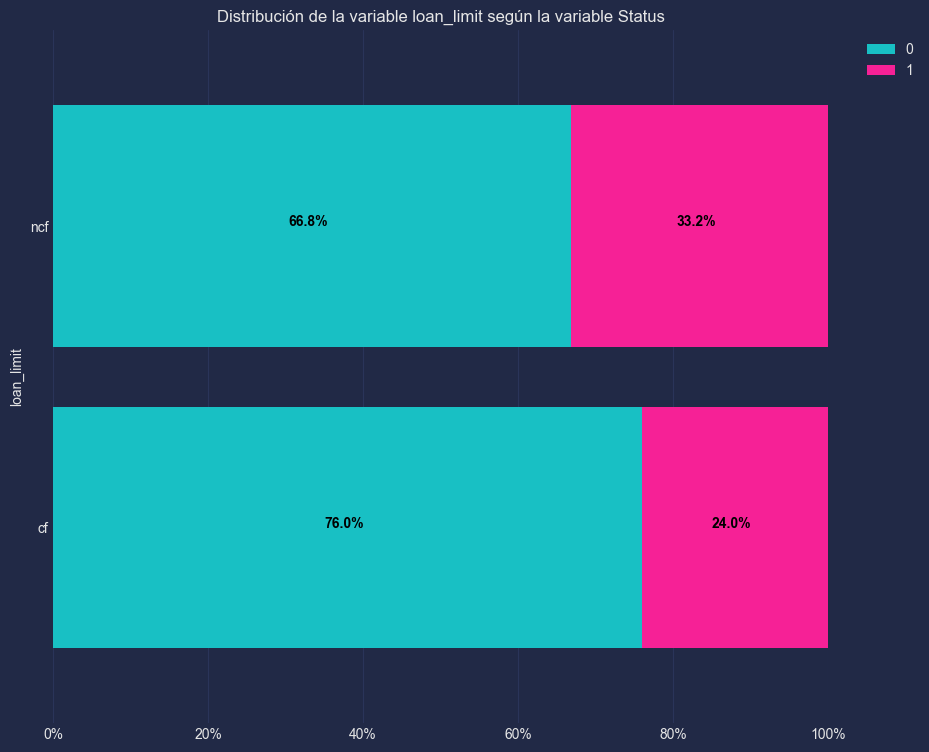

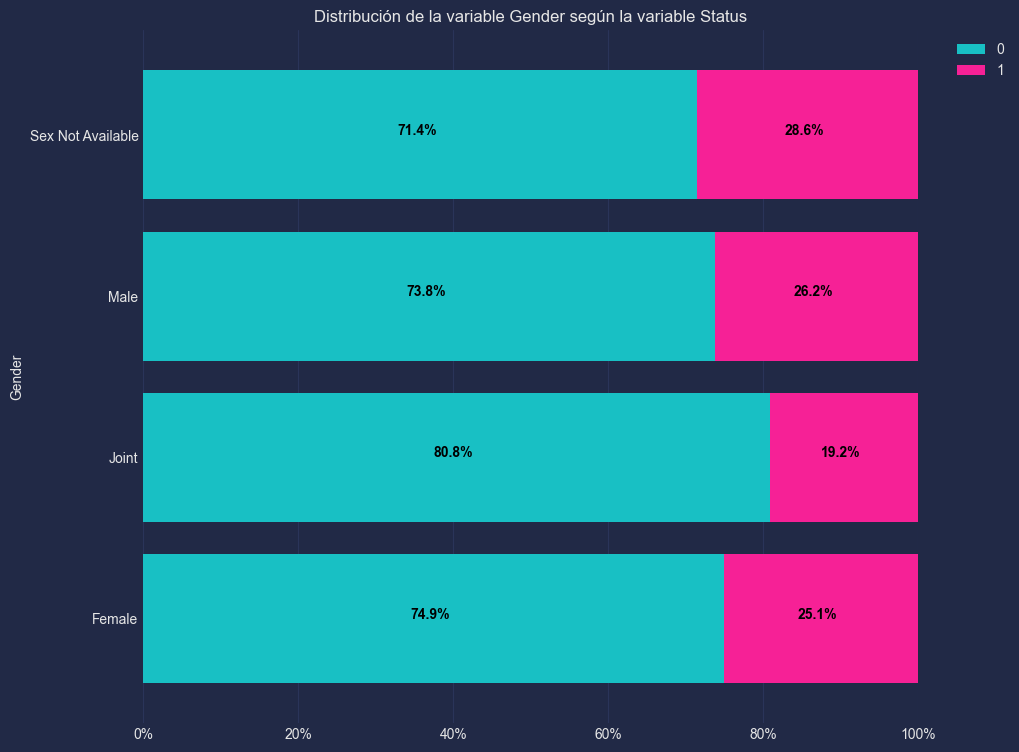

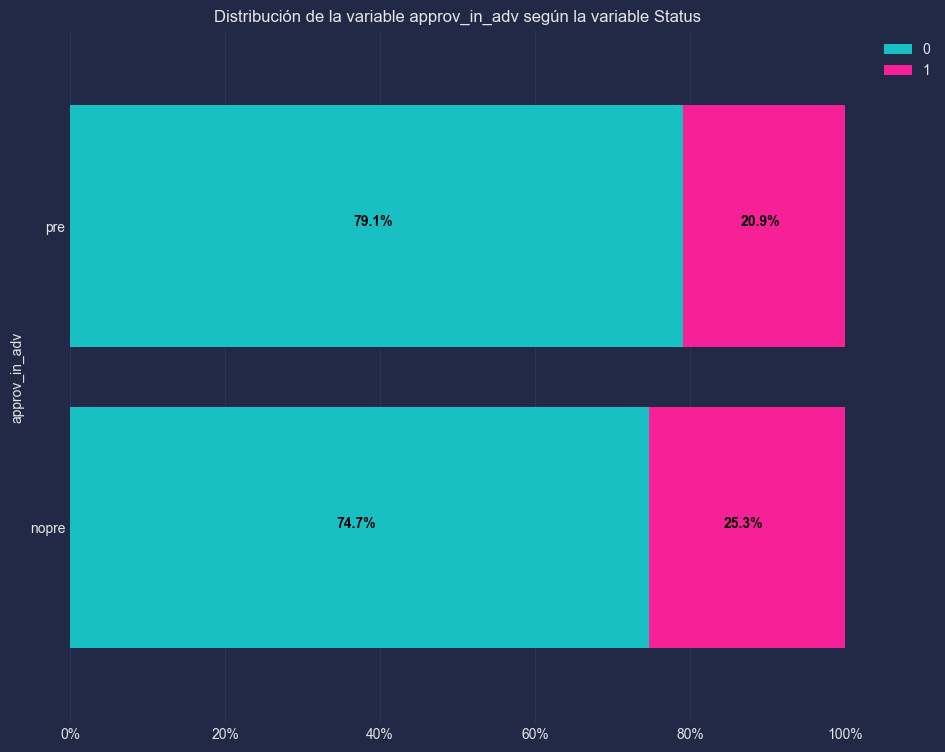

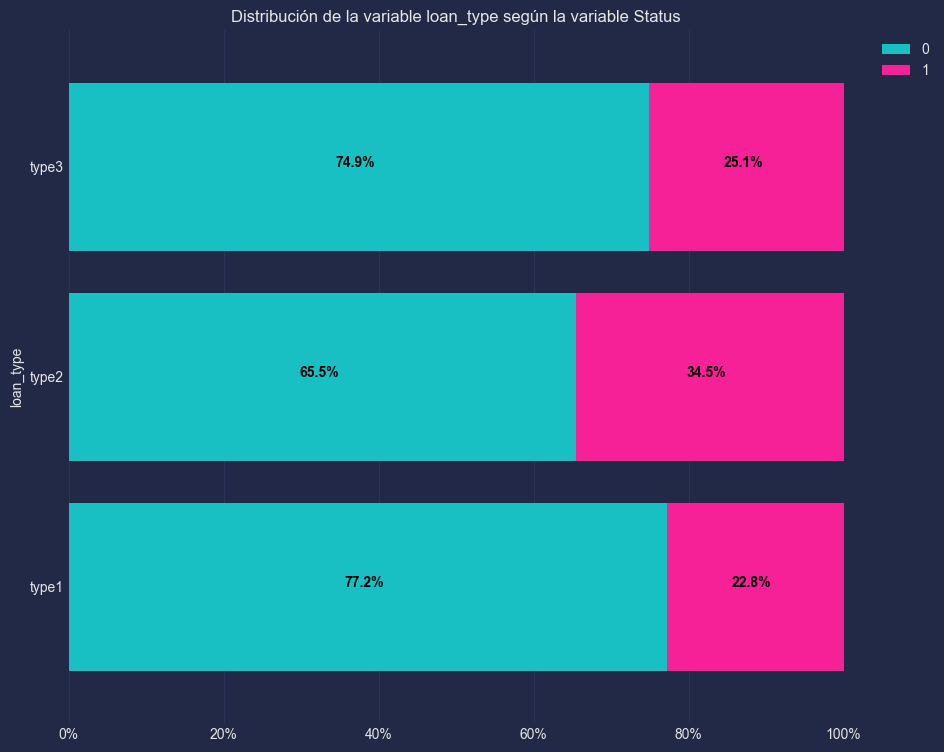

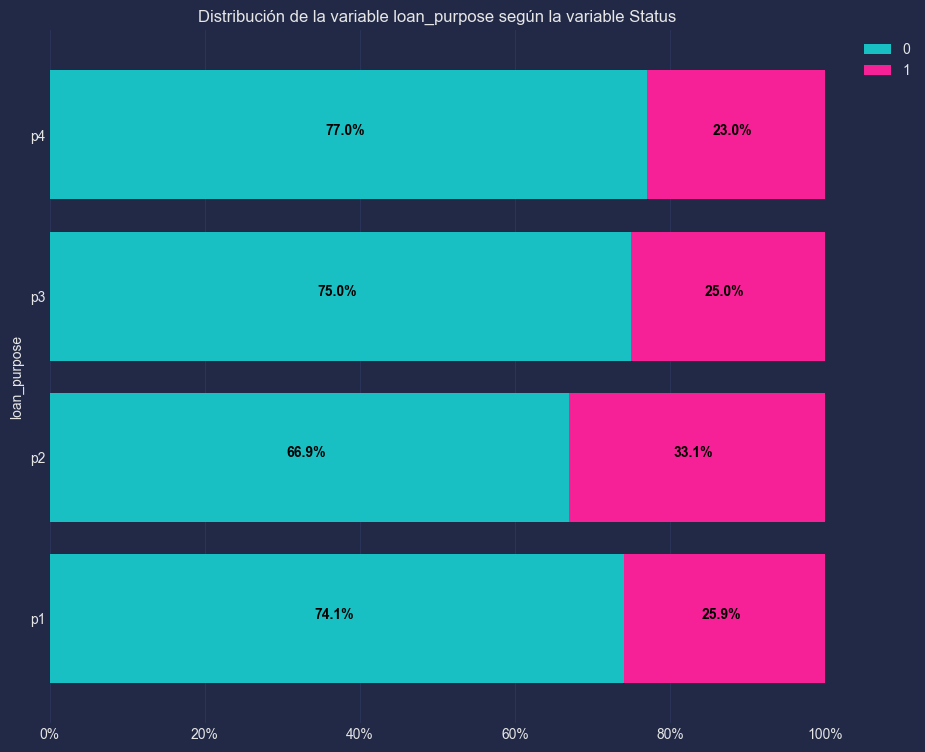

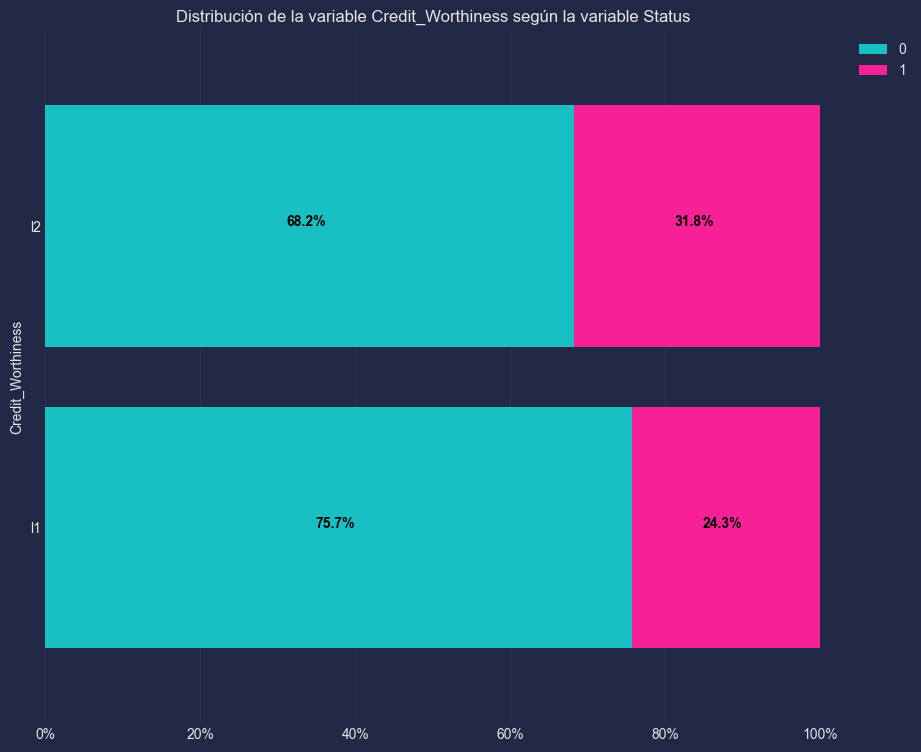

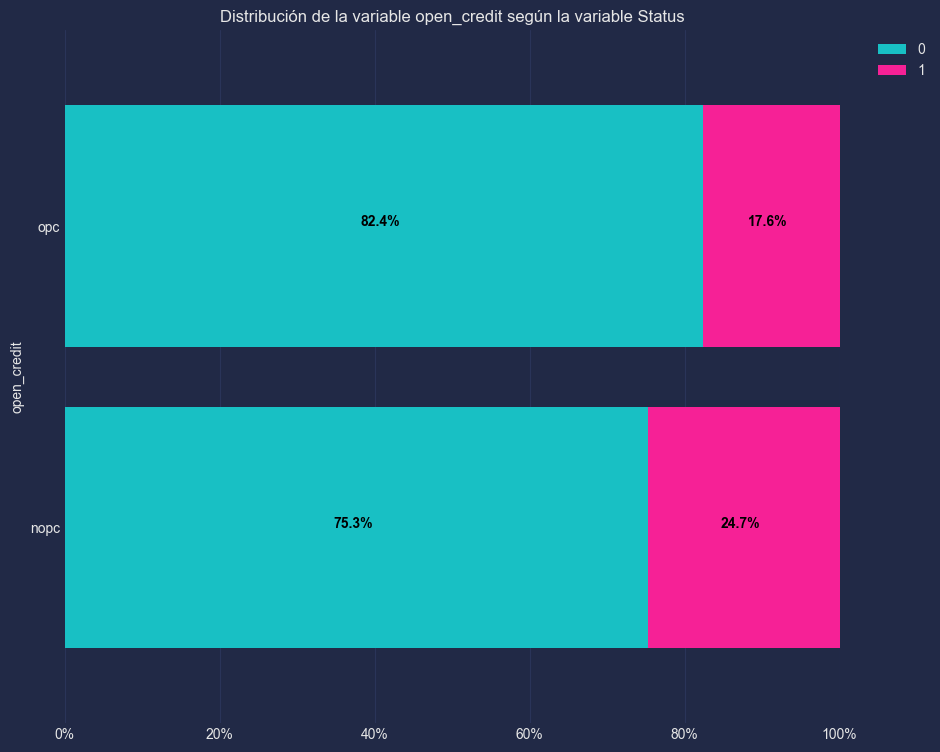

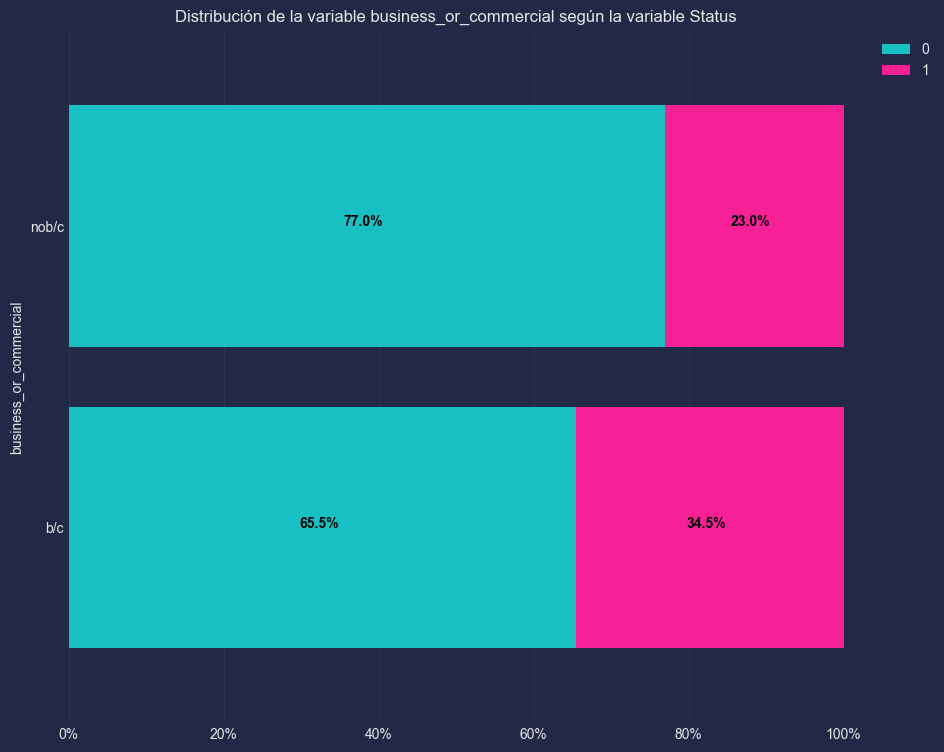

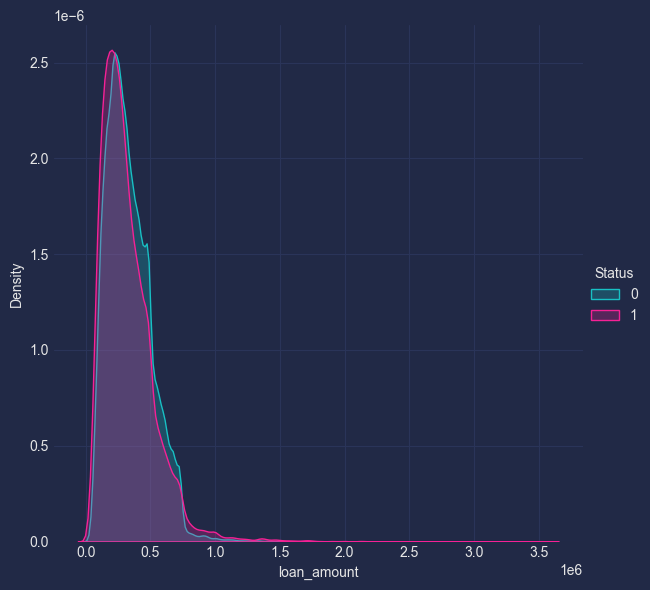

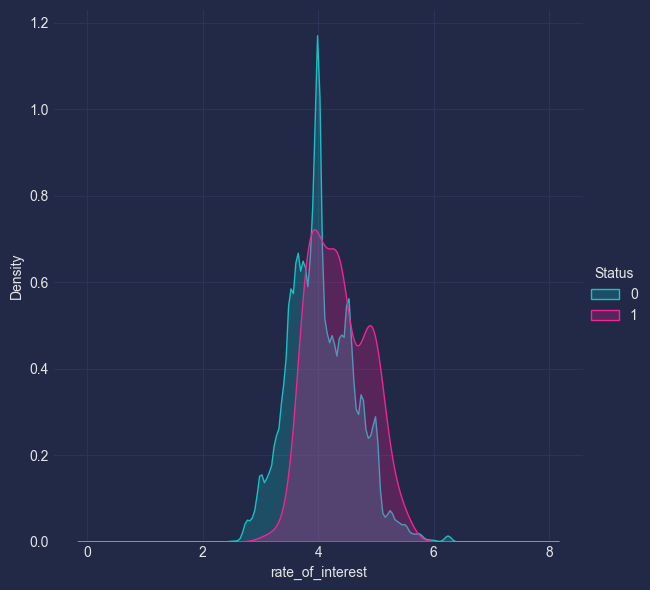

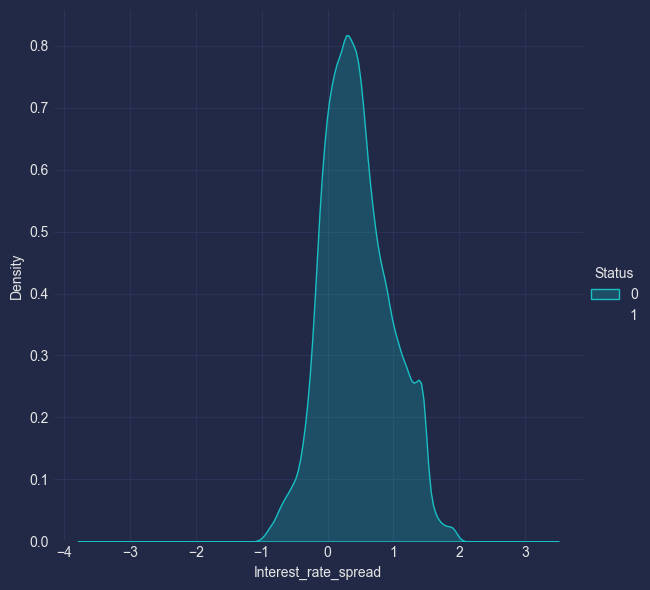

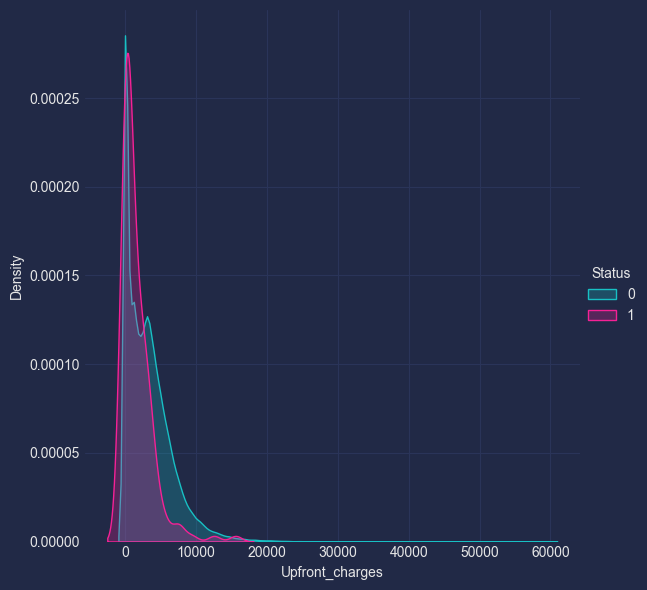

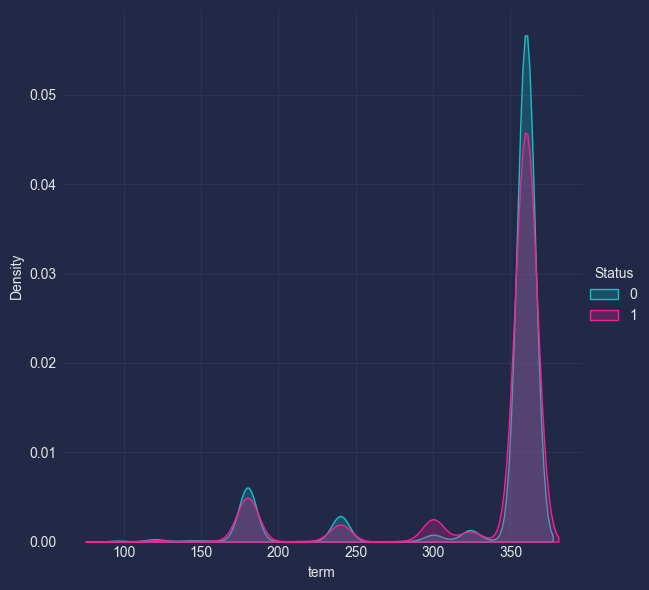

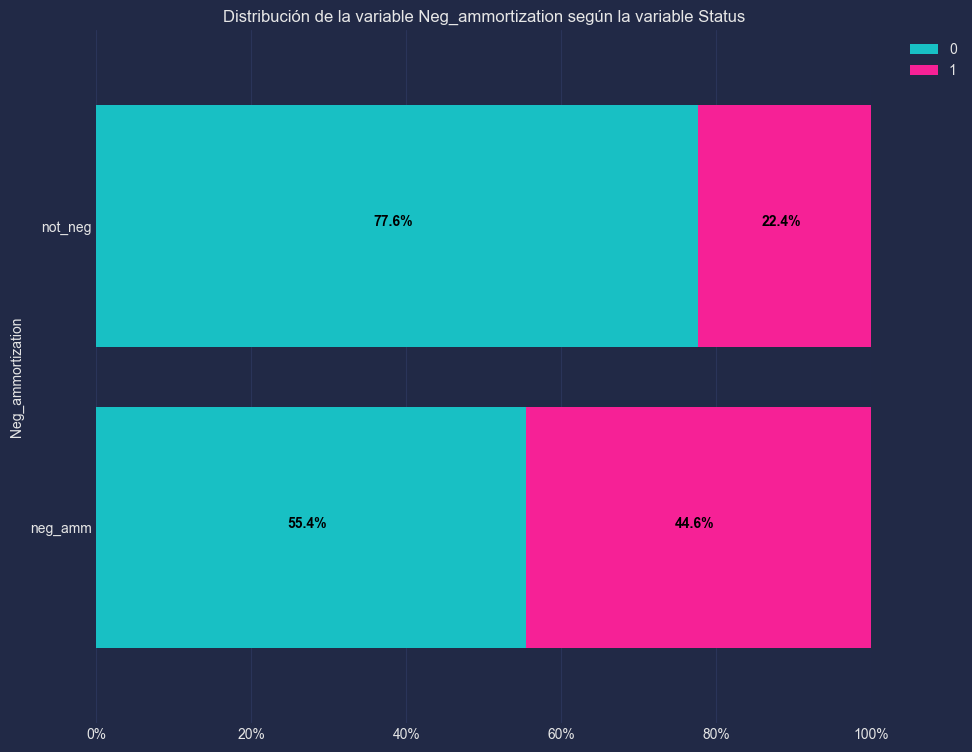

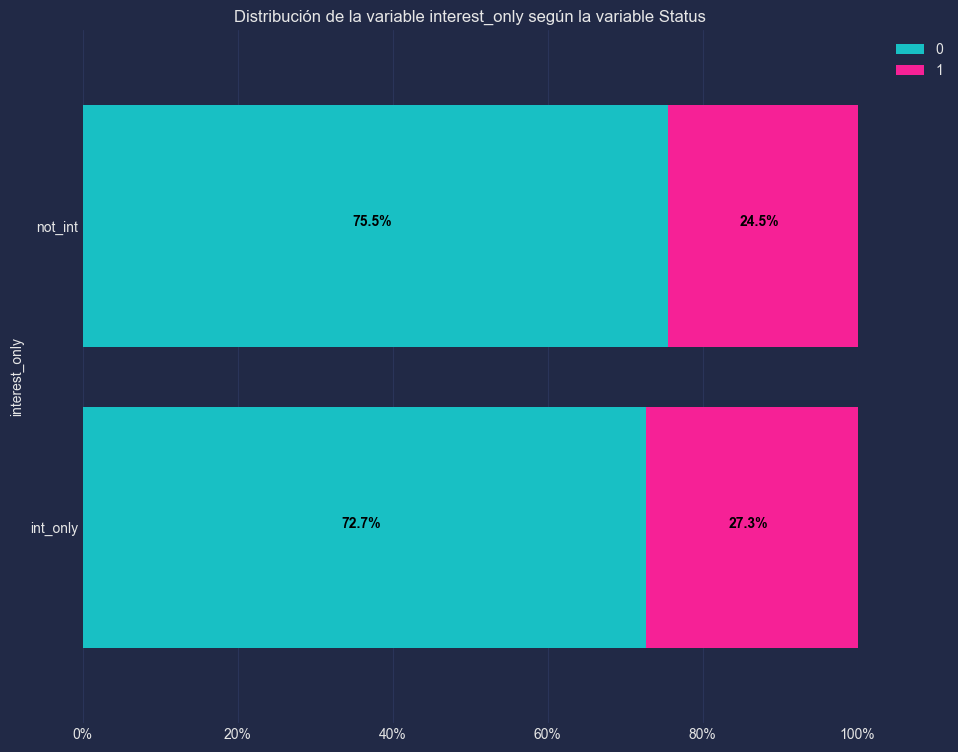

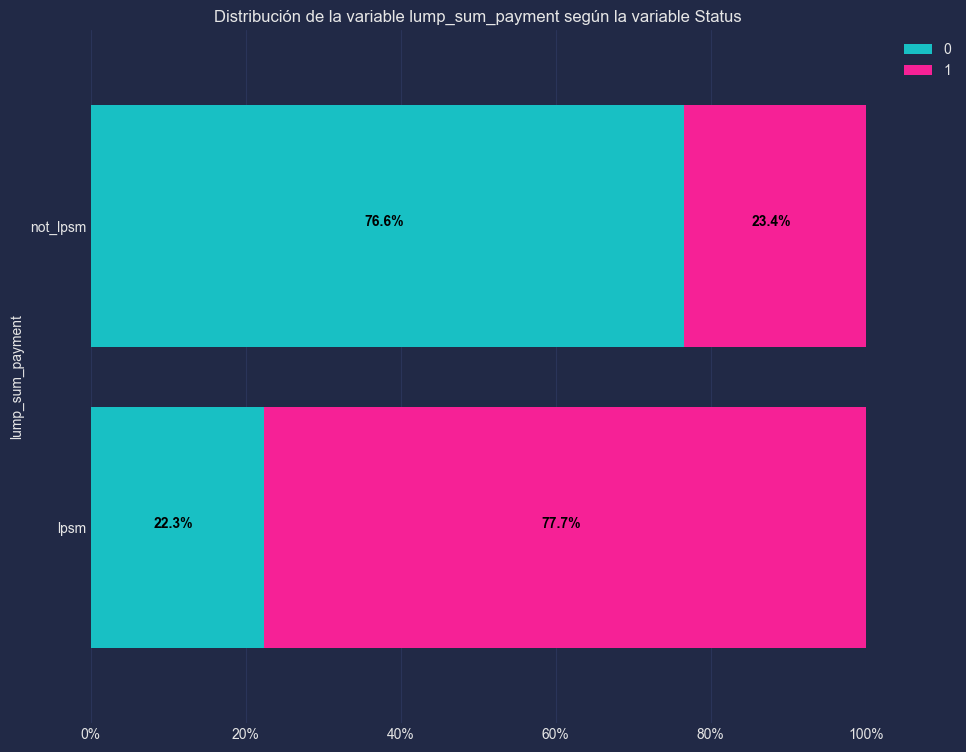

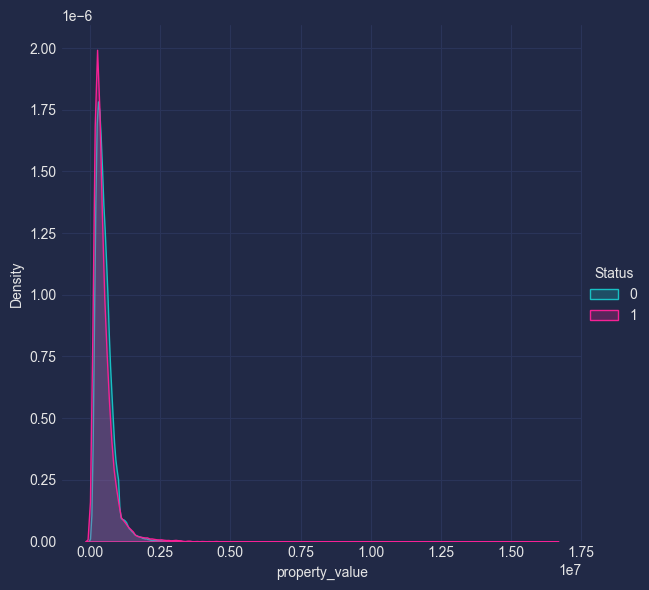

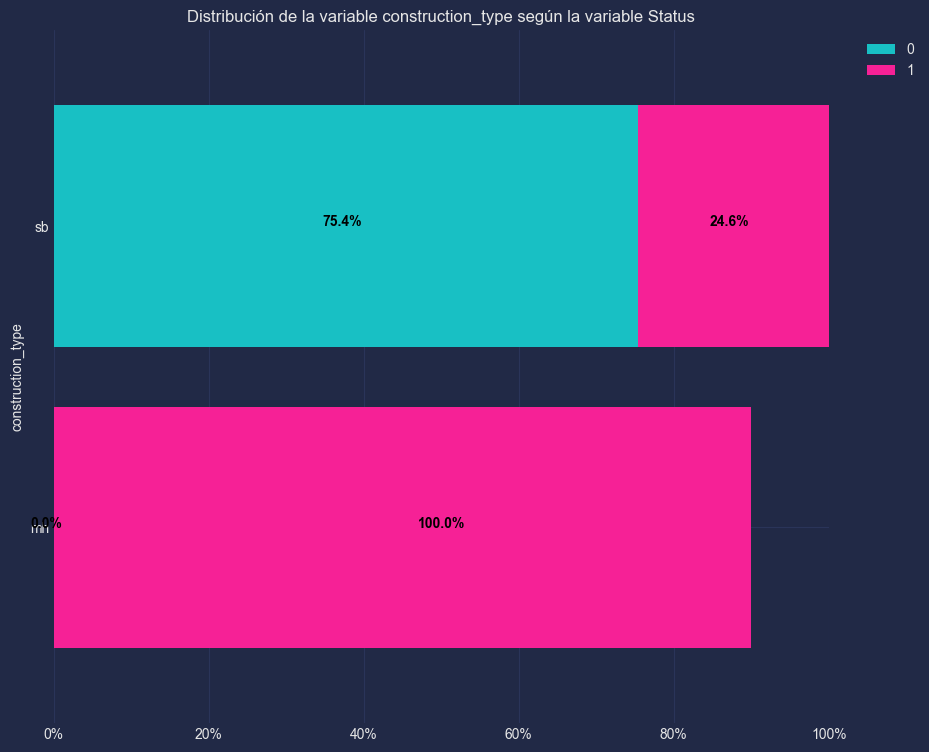

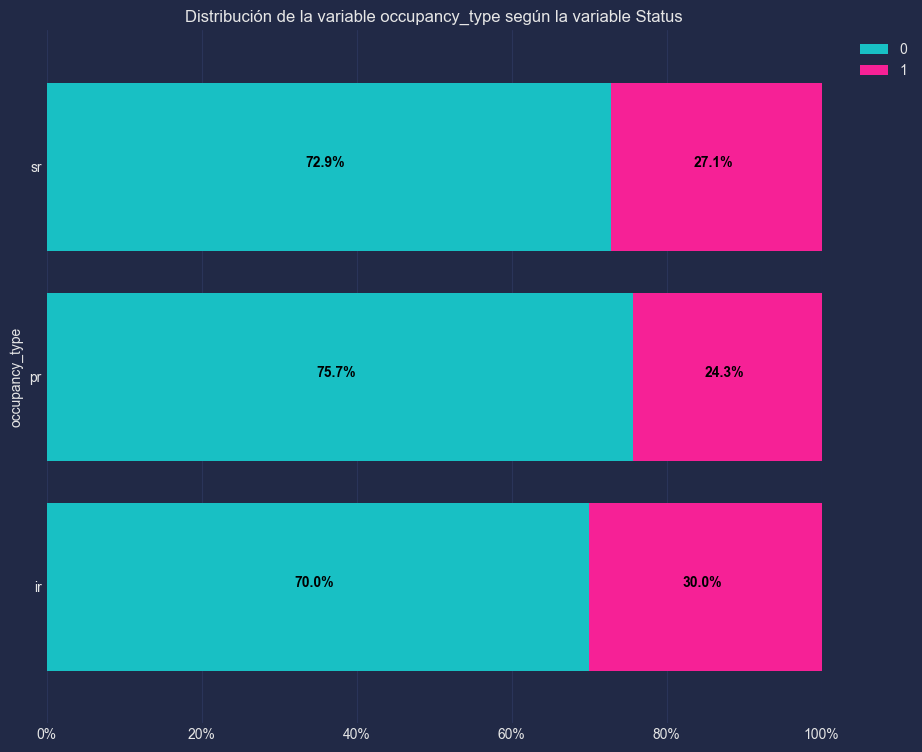

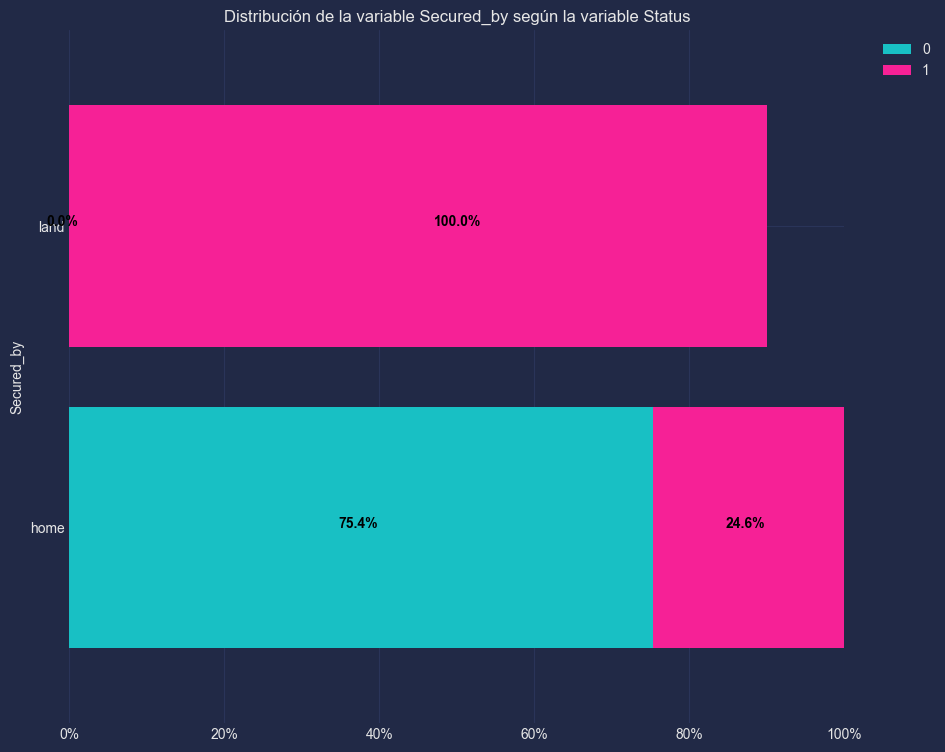

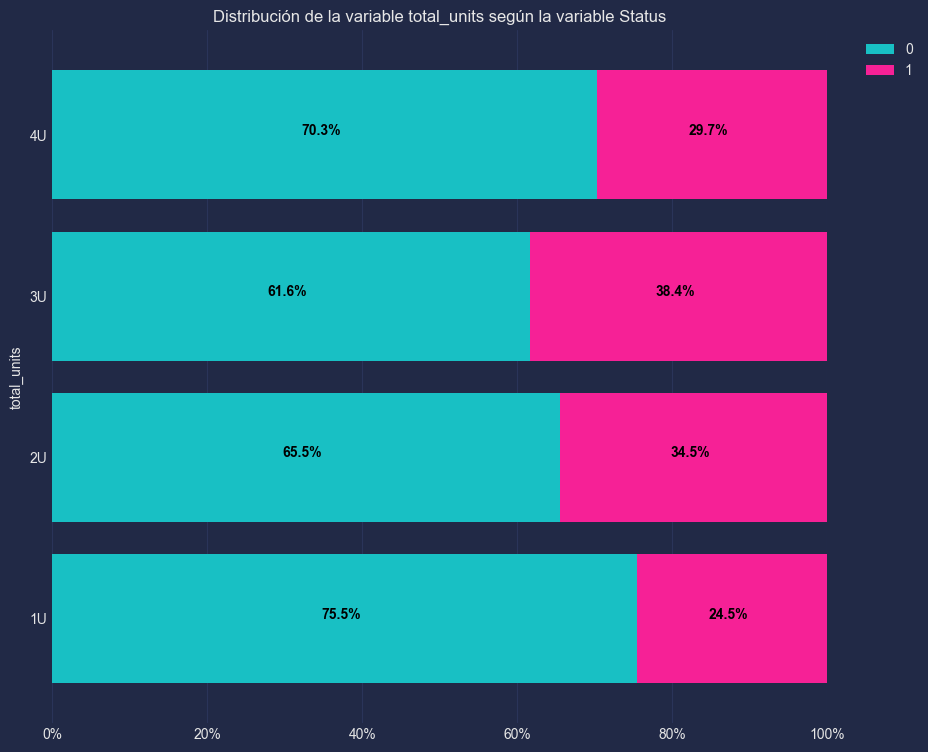

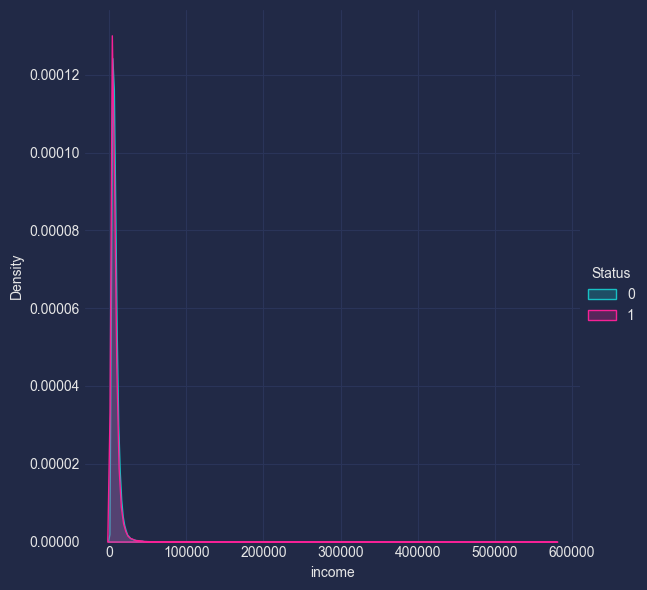

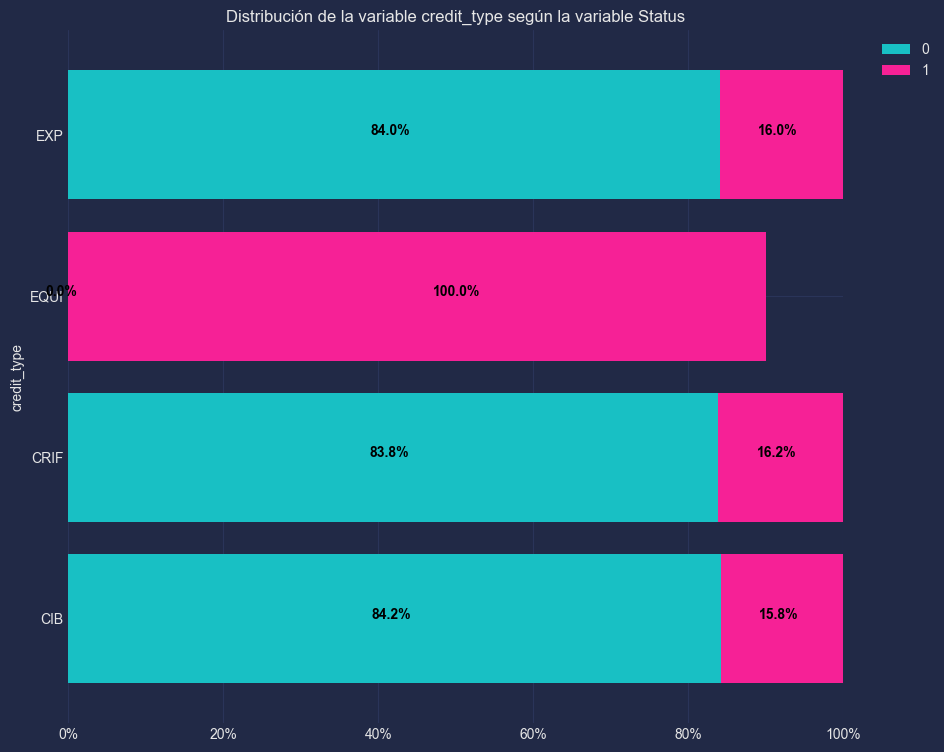

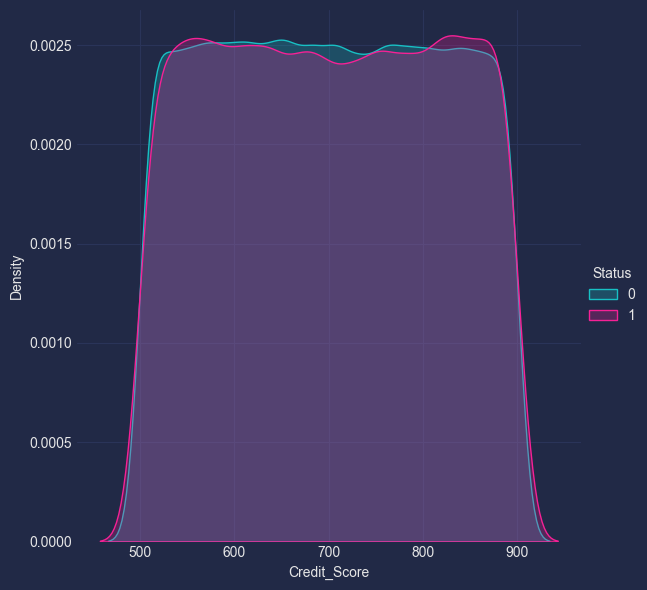

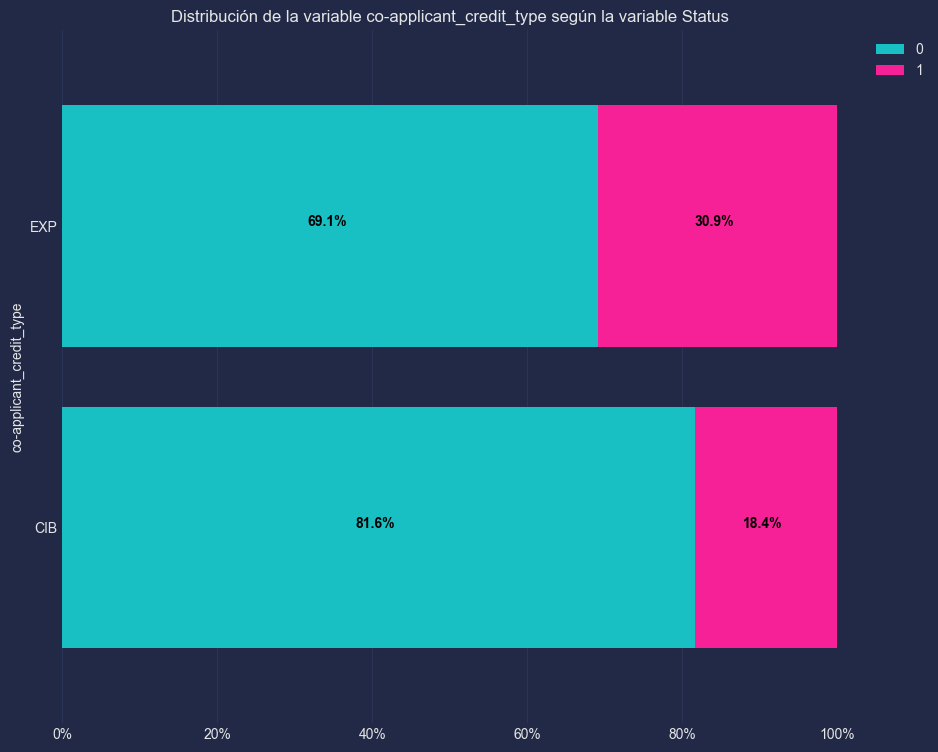

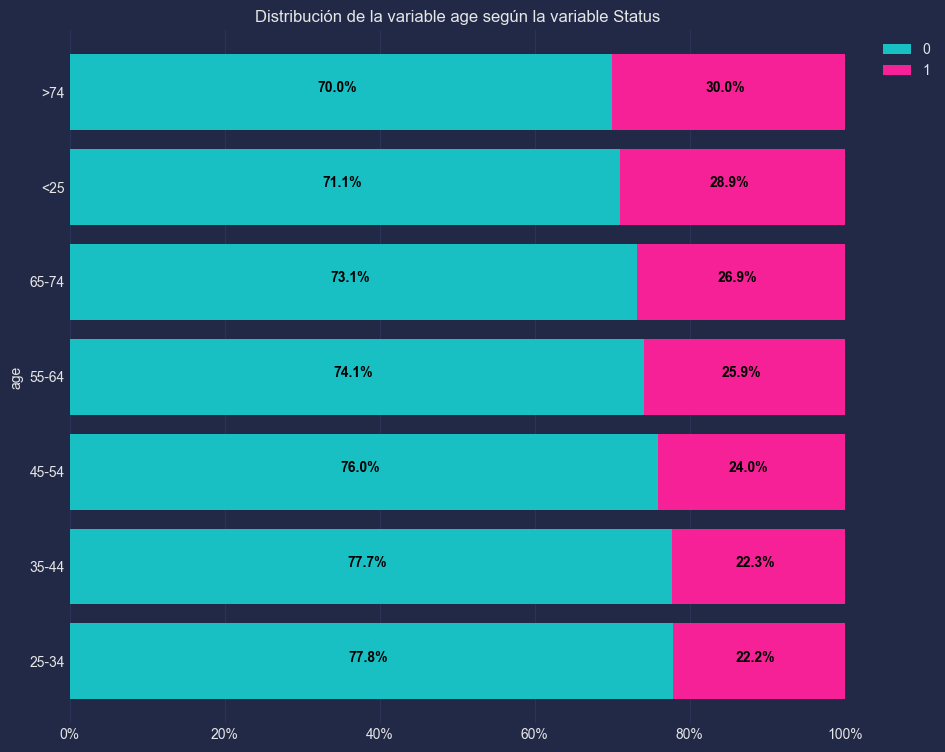

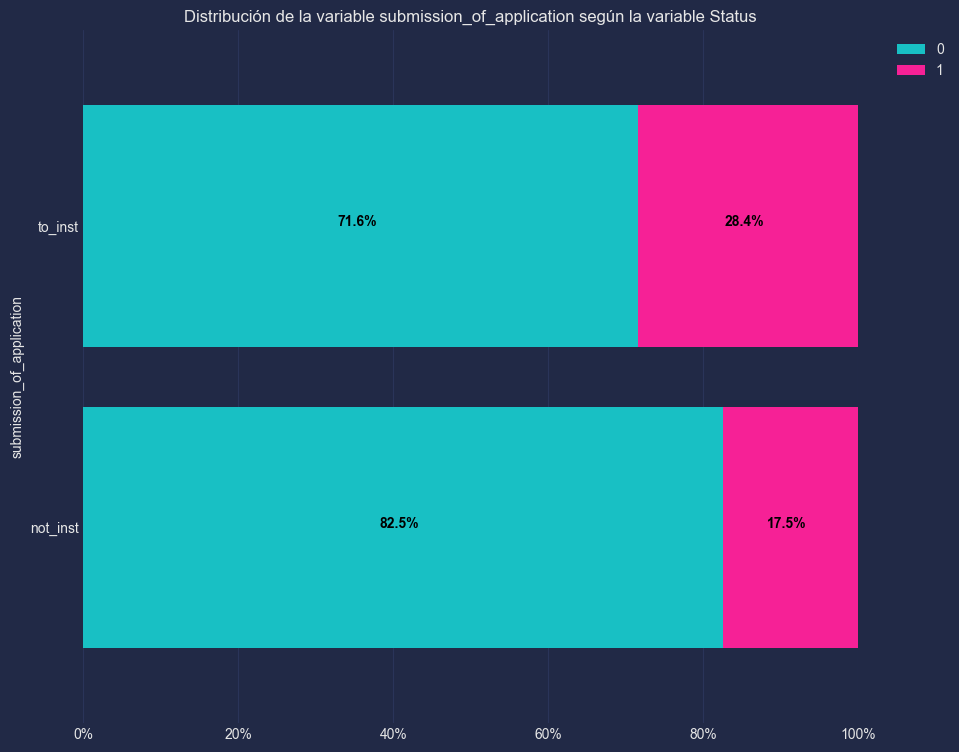

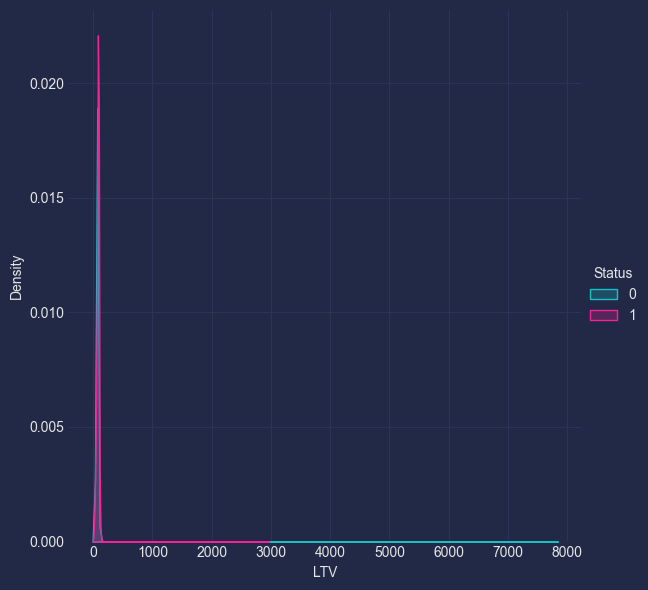

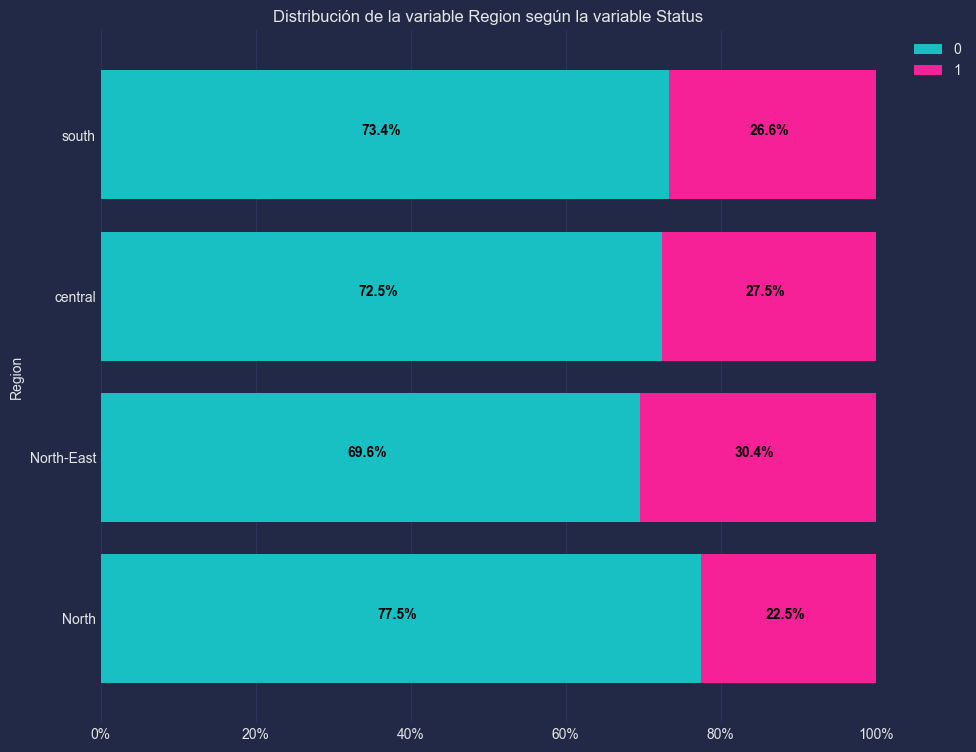

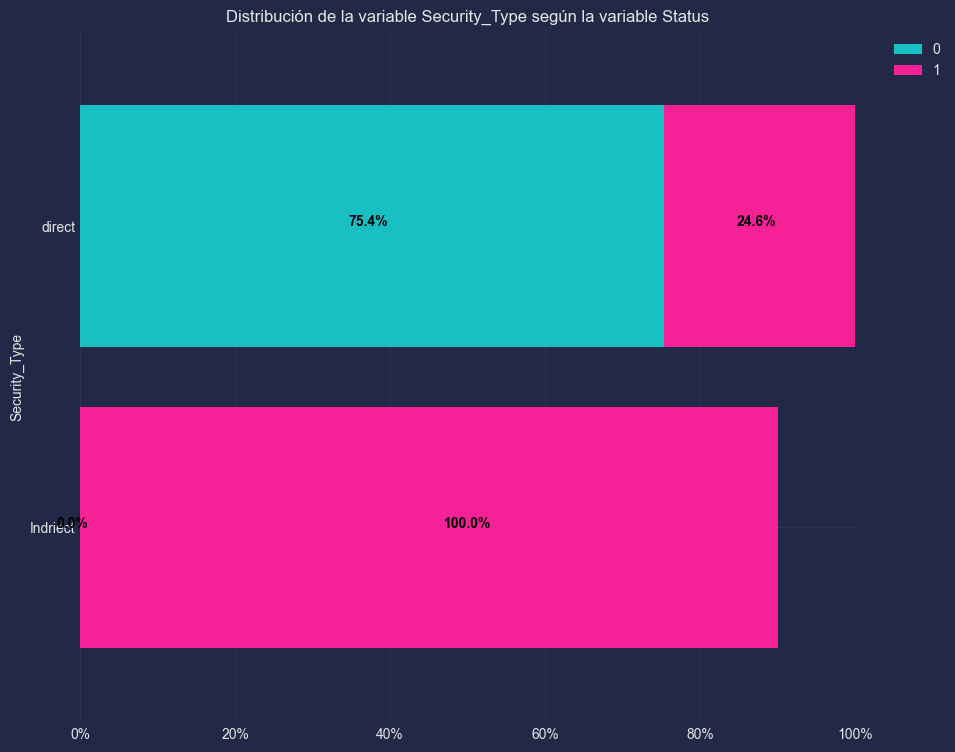

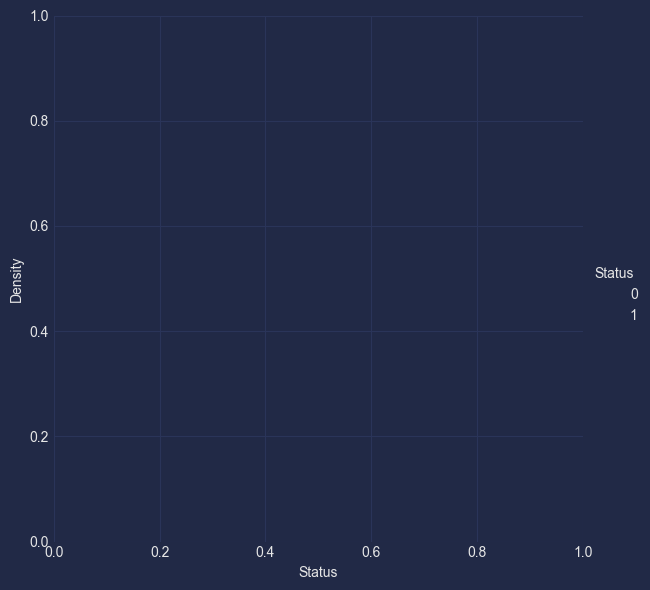

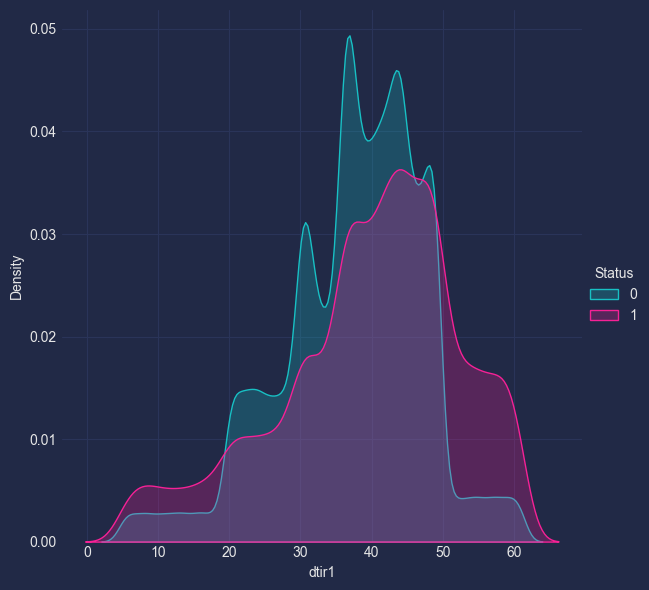

In [618]:
ap = Analisis_Predictivo(data, predecir = "Status")
for var in data.columns:
  if(data[var].dtype in ['float64', 'int', 'float','int64']):
    ap.poder_predictivo_numerica(var)
    plt.show()
  else:
    ap.poder_predictivo_categorica(var)
    plt.show()

# score, variabale sdmeograficas, dir1

In [619]:
data = data.drop(['loan_limit','approv_in_adv','interest_only','occupancy_type','LTV','income','construction_type'],axis = 1)

## Manejo de Nans

In [620]:
d_cgpt["Gender"] = d_cgpt["Gender"].replace("Sex Not Available", np.nan)
d_cgpt['Upfront_charges'] = np.where(d_cgpt['Upfront_charges'].isna() & d_cgpt['Status']==1 , 0, d_cgpt['Upfront_charges'])
aux = d_cgpt['Status']==0
l = []
for num,i in enumerate(d_cgpt['Upfront_charges'].isna()):
    l.append(aux[num] and i)
d_cgpt['Upfront_charges'] = np.where(l , 2000, d_cgpt['Upfront_charges'])
d_cgpt['LTV'] =  d_cgpt['LTV'].fillna(0)
d_cgpt['rate_of_interest'] = d_cgpt['rate_of_interest'].fillna(0)
d_cgpt['income'] = np.where(d_cgpt['income'].isna() & d_cgpt['Status']==1 , 0, d_cgpt['income'])
aux = d_cgpt['Status']==0
l = []
for num,i in enumerate(d_cgpt['income'].isna()):
    l.append(aux[num] and i)
d_cgpt['income'] = np.where(l , 5000, d_cgpt['income'])
d_cgpt = d_cgpt.dropna()

## Variables de clasificación a binaria

In [621]:

v_clasif1 = d_cgpt.dtypes.index[d_cgpt.dtypes == 'object']
for vc in v_clasif1:
    vals = d_cgpt[vc].value_counts().index
    for num,i in enumerate(vals):
        d_cgpt[vc] = np.where(d_cgpt[vc] ==i,num,d_cgpt[vc])


# MODELO

In [622]:
d_or_cgpt = d_cgpt.copy()
yvc = d_cgpt['Status'].value_counts()
aux = d_cgpt.sort_values('Status',ascending=True)
original_index = aux.index
aux = aux.reset_index()
L=sample(range(0,yvc[0]),yvc[0]-yvc[1])
d_cgpt_md = d_cgpt.copy()
aux = aux.drop(L,axis= 0)
old_index = set(original_index) - set(L)
aux = aux.sort_values('index')
d_cgpt = aux.drop(['index'],axis =1)
d_cgpt = d_cgpt.reset_index()

## An Factorial

In [623]:
aux = set(v_clasif1)
aux2 = set(d_cgpt.columns)
v_num = aux2-aux -set(['Status'])
v_c = d_cgpt[v_clasif1]
d_cgptn = d_cgpt[v_num]

v_or_c = d_or_cgpt[v_clasif1]
d_or_cgptn = d_or_cgpt[v_num - set(['index'])]

In [624]:
def agregar_datos_2(resul,nfac):
    resul['Comunalidad'] =  [np.sum(np.array(resul.iloc[i]**2)[:-1]) for i in range(len(resul))]
    a = [np.sum(np.array(resul[i]**2)) for i in range(nfac)] 
    a = pd.DataFrame(a,columns = ['Var']).T
    a['Comunalidad'] = a.T.sum()[0]
    b = a/12;b = b.rename({'Var':'%Var'})
    a = a.append(b)
    resul = resul.append(a)
    rep_por_fac = pd.DataFrame(resul.T.drop(['Comunalidad']).idxmax(),columns=['Factores'])[:-2].sort_values('Factores')
    return resul,rep_por_fac

def af2(data,nfac,rotation):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    if nfac == None:
        fa = FactorAnalyzer(method ='ml',rotation = rotation) #Analisis factorial exploratior
    else:
        fa = FactorAnalyzer(nfac,method ='ml',rotation = rotation) #Analisis factorial exploratior
    #Aqui por defecto lo hace con tres factores
    fa.fit(scaled_data)
    resul = fa.loadings_
    resul = pd.DataFrame(resul,index = data.columns)
    if nfac == None:
        resul,rep_por_fac = agregar_datos_2(resul,len(resul.T))
    else:
        resul,rep_por_fac = agregar_datos_2(resul,nfac)
    return resul,rep_por_fac,fa
resul1,rep_por_fac1,fa1 = af2(d_cgptn,2,'oblimin')
resul2,rep_por_fac2,fa2 = af2(d_or_cgptn,2,'oblimin')

In [625]:
facts1 = pd.DataFrame(fa1.fit_transform(d_cgptn,d_cgpt['Status']))
facts2 = pd.DataFrame(fa2.fit_transform(d_or_cgptn.drop(['Upfront_charges'],axis = 1),d_or_cgpt['Status']))

## Analisis discriminantes

In [626]:
abc = d_or_cgpt.dtypes[d_or_cgpt.dtypes == object]

In [627]:
facts1.columns = facts1.columns.astype(str)
facts2.columns = facts1.columns.astype(str)
df3 = pd.concat([facts1,d_cgpt],axis=1)
df4 = pd.concat([facts2,d_or_cgpt.reset_index()],axis=1)
df3 = df3.drop(['index'],axis = 1)

In [628]:
lda = LinearDiscriminantAnalysis()
analisis_Iris3 = Analisis_Predictivo(df3.drop(['rate_of_interest','Upfront_charges'],axis=1), predecir = "Status", modelo = lda, 
                                    train_size = 0.7, random_state = 0)
print("Las predicciones en Testing son: {}".format(analisis_Iris3.fit()))
resultados = analisis_Iris3.fit_predict_resultados() #rattle

Las predicciones en Testing son: [0 0 0 ... 0 0 0]

Matriz de Confusión:
[[4274    0]
 [   0 4306]]

Precisión Global:
1.0

Error Global:
0.0

Precisión por categoría:
     0    1
0  1.0  1.0


tomar la tabla des testing, se estandariza -mu y divido sobre sigma , 

In [629]:
precision = resultados['Matriz de Confusión'][0][0] / (resultados['Matriz de Confusión'][0][0] +resultados['Matriz de Confusión'][0][1])
exhaustividad = resultados['Matriz de Confusión'][0][0] / (resultados['Matriz de Confusión'][0][0] +resultados['Matriz de Confusión'][1][0])
f_score = 2/ (1/precision + 1/exhaustividad)
print(f_score)

1.0


In [630]:
lda = LinearDiscriminantAnalysis()
analisis_Iris3 = Analisis_Predictivo(df4, predecir = "Status", modelo = lda, #df4.drop(['rate_of_interest','Upfront_charges','index'],axis =1)
                                    train_size = 0.7, random_state = 0)
resultados = analisis_Iris3.fit_predict_resultados()


Matriz de Confusión:
[[23818     0]
 [    0  4288]]

Precisión Global:
1.0

Error Global:
0.0

Precisión por categoría:
     0    1
0  1.0  1.0


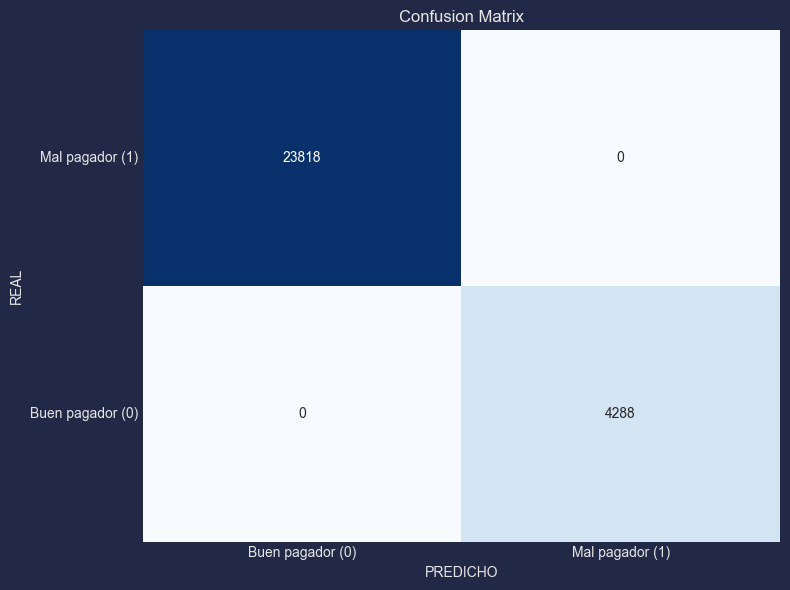

In [631]:
plt.figure(figsize=(8, 6))
sns.heatmap(resultados['Matriz de Confusión'], annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('PREDICHO')
plt.ylabel('REAL')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Buen pagador (0)','Mal pagador (1)'])
plt.yticks([0.5, 1.5], ['Mal pagador (1)','Buen pagador (0)'], rotation=0)
plt.tight_layout()
plt.show()

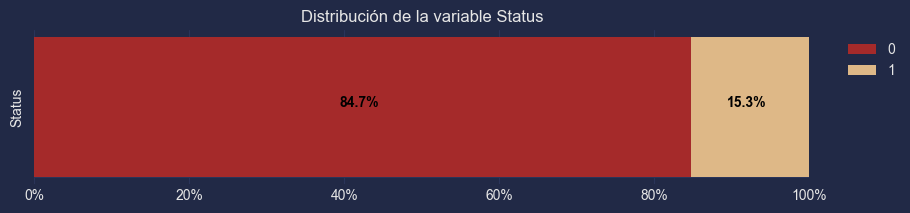

In [632]:
analisis_Iris3.distribucion_variable_predecir()

In [633]:
fv = analisis_Iris3.X_test[analisis_Iris3.X_test.columns].dtypes[analisis_Iris3.X_test[analisis_Iris3.X_test.columns].dtypes == object].index
fv = set(fv)
fvn =   set(analisis_Iris3.X_test[analisis_Iris3.X_test.columns].columns) -fv

# df_resul = analisis_Iris3.X_test
# df_resul['Status_pred'] = analisis_Iris3.fit()
# df_resul = df_resul.reset_index()
# aux = df_resul[df_resul['Status_pred']==1]
# aux = aux.drop(['index','Status_pred'],axis = 1)
# plt.figure()
# fig,axs = plt.subplots(7,1,layout="constrained",figsize = (10,15))
# for num,i in enumerate(fvn -set(['Status_pred'])):
#     axs[num].hist(aux[i],bins = 20)
#     axs[num].set_title(i)
#     axs[num].legend(['Predicha'])
# plt.show()

In [634]:
data["Gender"] = data["Gender"].replace("Sex Not Available", np.nan)

## Ahora intentemos con logistica

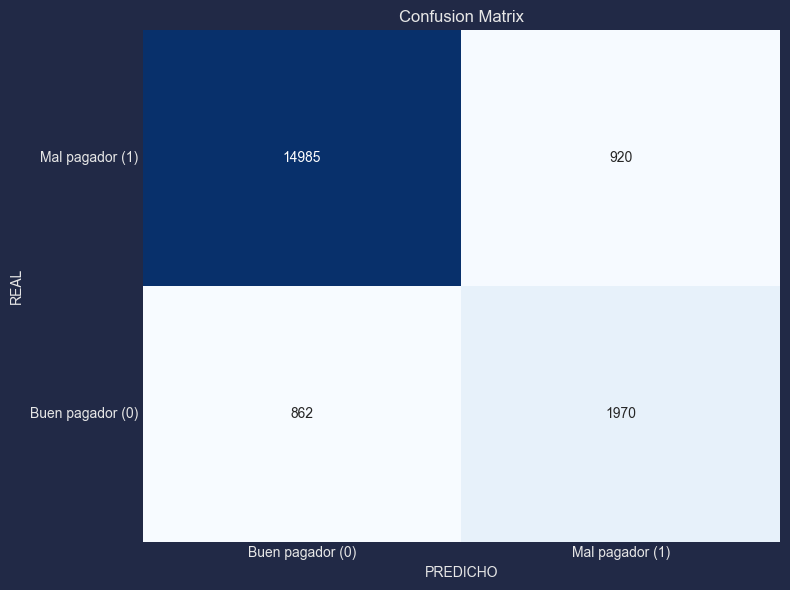

In [637]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = df4.drop(["Status",'index','rate_of_interest'], axis=1)
y = df4["Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('PREDICHO')
plt.ylabel('REAL')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Buen pagador (0)','Mal pagador (1)'])
plt.yticks([0.5, 1.5], ['Mal pagador (1)','Buen pagador (0)'], rotation=0)
plt.tight_layout()
plt.show()


In [638]:
# Crear una instancia del modelo de regresión logística
model = LogisticRegression()

# Ajustar el modelo a tus datos de entrenamiento
model.fit(X_train, y_train)

# Obtener los coeficientes (pesos) de las variables clasificatorias
coefficients = model.coef_

# También puedes obtener el intercepto (sesgo) del modelo
intercept = model.intercept_

# Ahora, coefficients contendrá los pesos asociados a cada variable clasificatoria
# y intercept contendrá el término de sesgo (intercepto) del modelo.

# Imprimir los coeficientes de las variables
for feature, coef in zip(X_train.columns, coefficients[0]):
    print(f'{feature}: {coef}')

# Si necesitas las probabilidades predichas, puedes usar predict_proba
y_pred_proba = model.predict_proba(X_test)

0: -5.43726543336385e-05
1: 0.001981545796402487
Credit_Worthiness: 0.00022657461995904295
loan_amount: -3.1954907670352474e-06
income: -2.6662907204572295e-05
Credit_Score: 0.0007118237260188316
LTV: 0.005935195581879046
Gender: -0.0004677890075656142
loan_purpose: -0.0021810923179409352
open_credit: 2.2444831386097906e-05
Upfront_charges: -3.332290128552822
age: 0.0016273176730608302
dtir1: 0.011102771394654523


y_pred_proba

In [639]:
proby_pred = pd.DataFrame(y_pred_proba,columns = ['prob_0', 'prob_1'])

In [640]:
df_prob = pd.concat([proby_pred,X_test.reset_index()],axis = 1)

<Figure size 640x480 with 0 Axes>

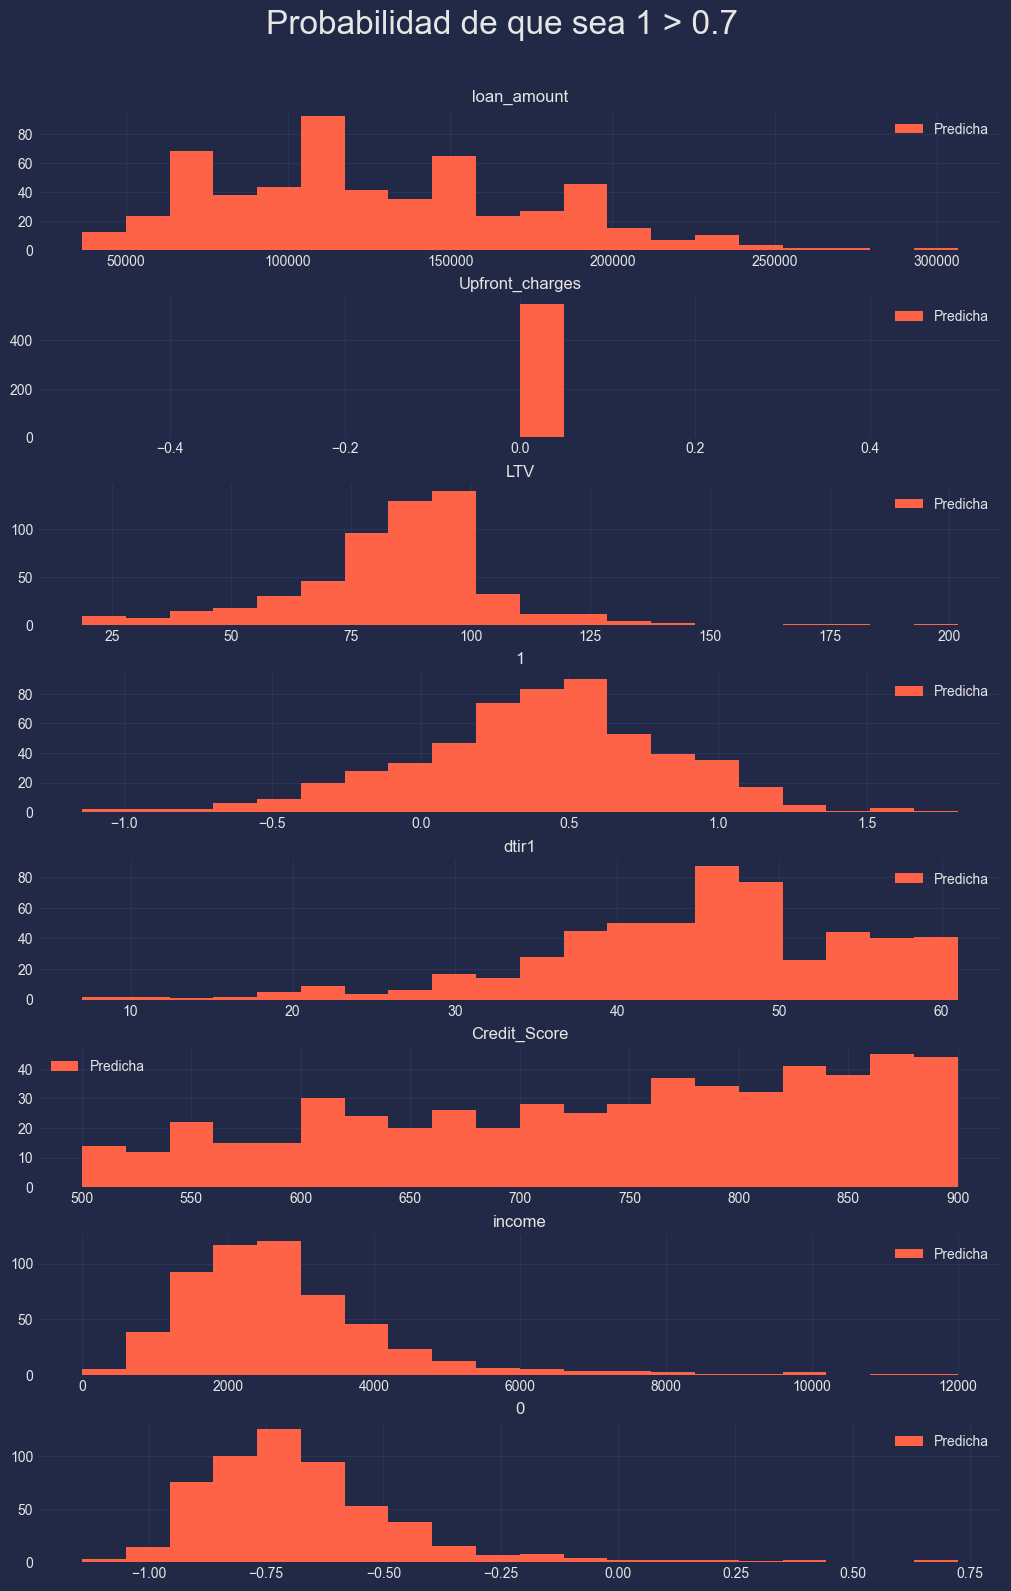

In [641]:
prob1_char =  df_prob[df_prob['prob_1']>=0.7]

plt.figure()
fig,axs = plt.subplots(8,1,layout="constrained",figsize = (10,15))
fig.text(0.26, 1.04, 'Probabilidad de que sea 1 > 0.7', va='center', ha = 'left',fontsize=24)
for num,i in enumerate(fvn -set(['Status_pred','rate_of_interest']) - set(['index'])):
    axs[num].hist(prob1_char[i],bins = 20,color = 'tomato')
    axs[num].set_title(i)
    axs[num].legend(['Predicha'])
plt.show()




<Figure size 640x480 with 0 Axes>

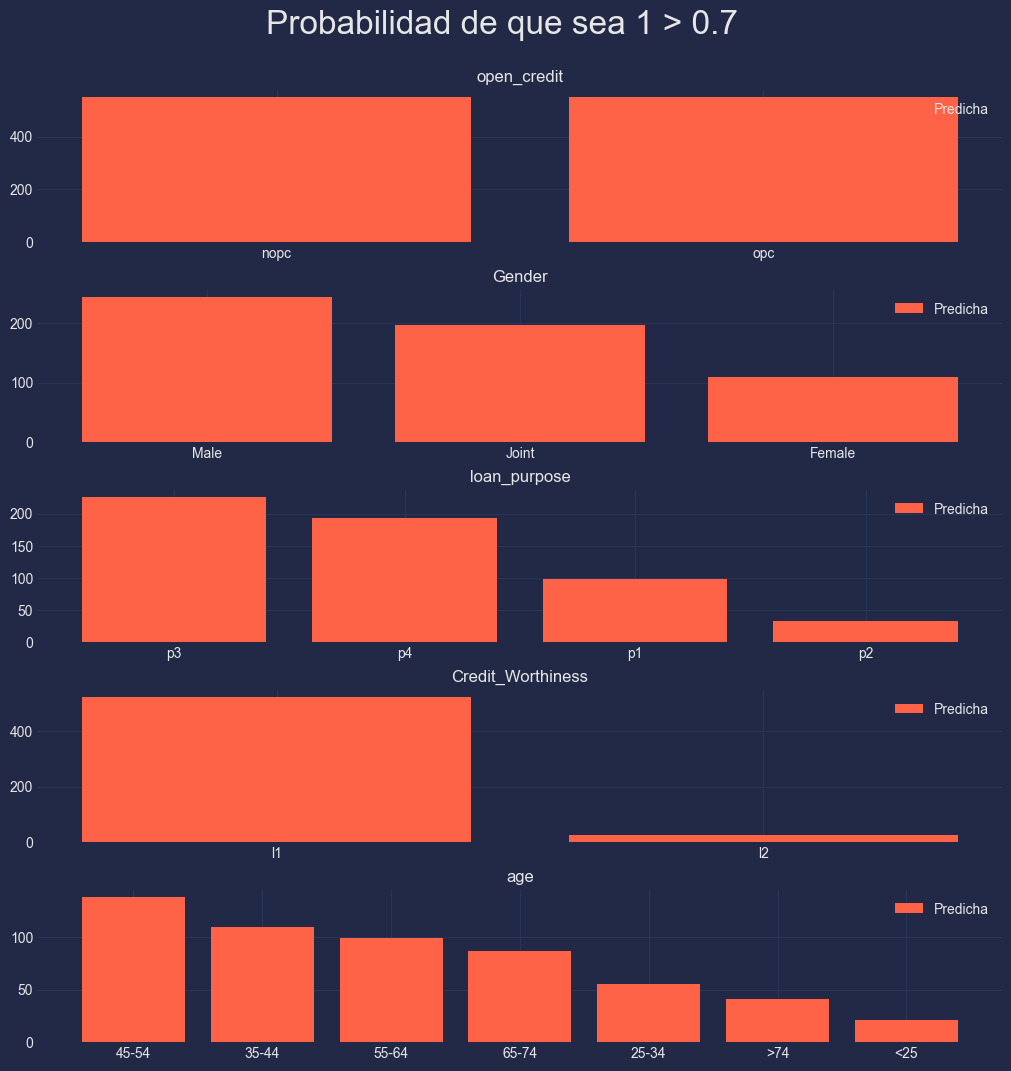

In [652]:
plt.figure()
fig,axs = plt.subplots(5,1,layout="constrained",figsize = (10,10))
fig.text(0.26, 1.04, 'Probabilidad de que sea 1 > 0.7', va='center', ha = 'left',fontsize=24)
for num,i in enumerate(fv):
    axs[num].bar(data[i].value_counts().index,prob1_char[i].value_counts(),color = 'tomato')
    axs[num].set_title(i)
    axs[num].legend(['Predicha'])
plt.show()

<Figure size 640x480 with 0 Axes>

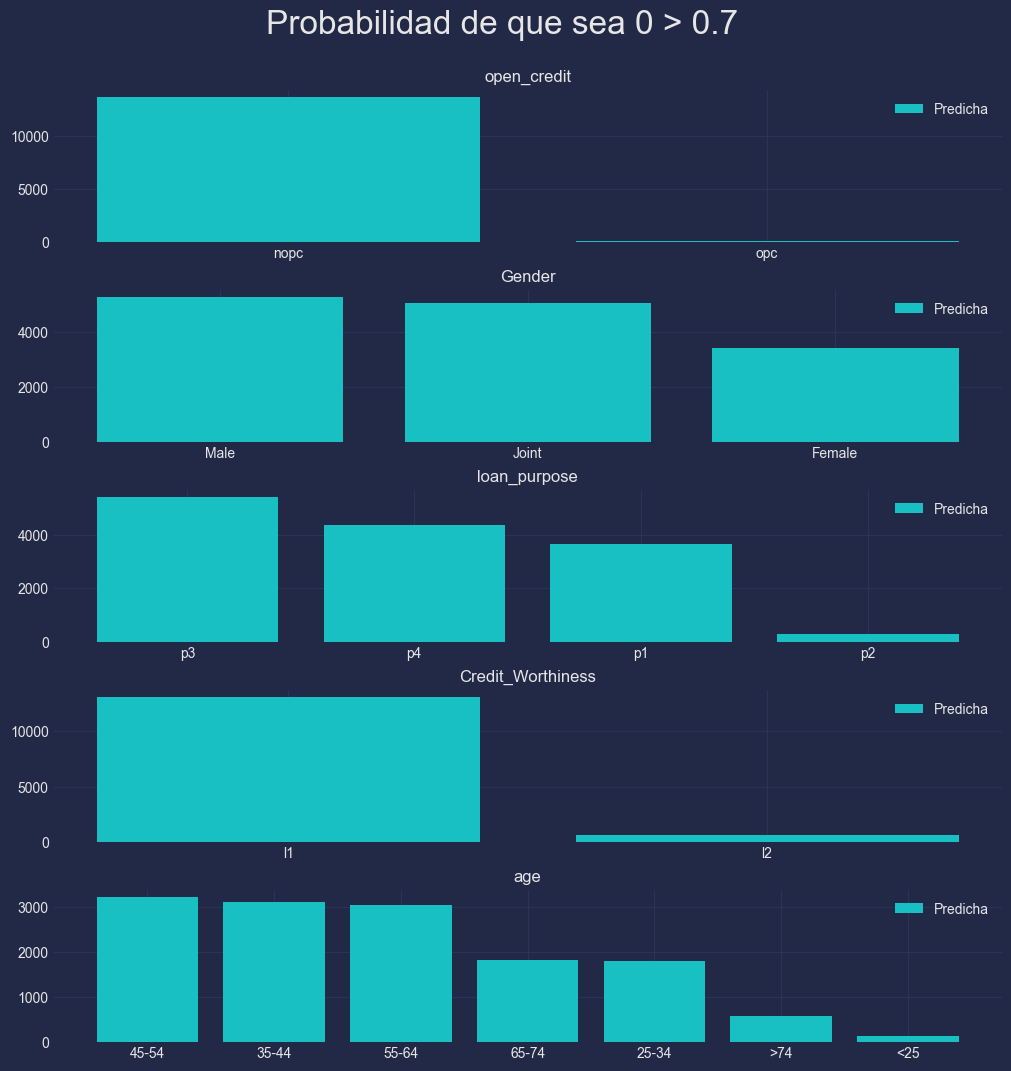

In [653]:
prob0_char = df_prob[df_prob['prob_0']>=0.7]
plt.figure()
fig,axs = plt.subplots(5,1,layout="constrained",figsize = (10,10))
fig.text(0.26, 1.04, 'Probabilidad de que sea 0 > 0.7', va='center', ha = 'left',fontsize=24)
for num,i in enumerate(fv):
    axs[num].bar(data[i].value_counts().index,prob0_char[i].value_counts())
    axs[num].set_title(i)
    axs[num].legend(['Predicha'])
plt.show()

loan_amount
Upfront_charges
LTV
1
dtir1
Credit_Score
income
0


<Figure size 640x480 with 0 Axes>

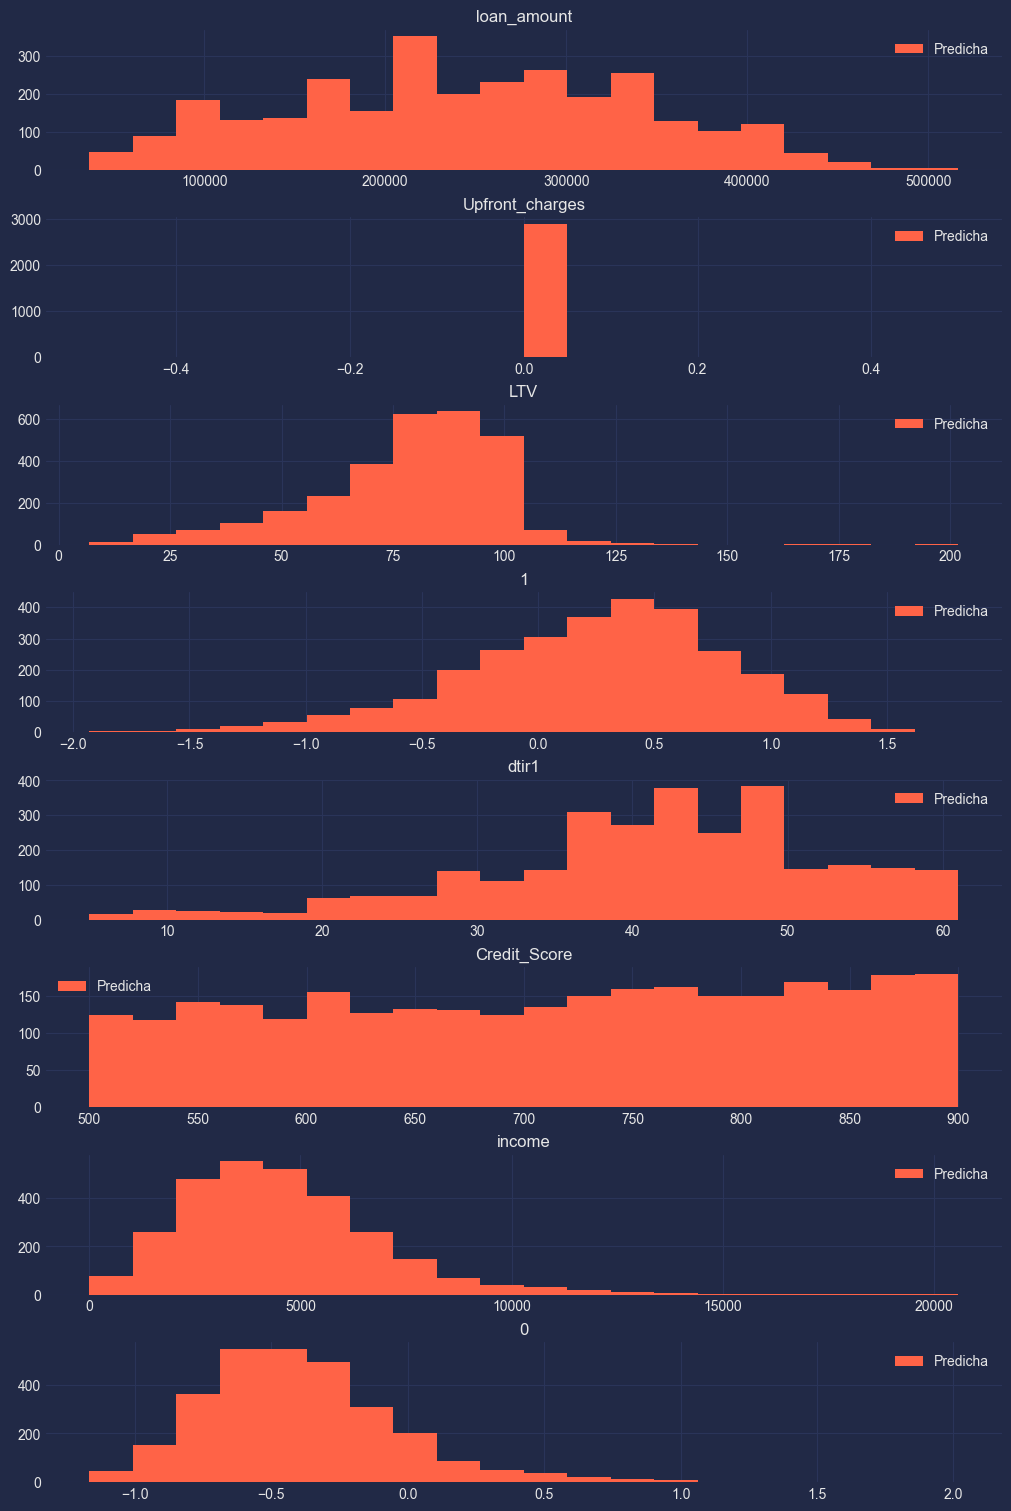

In [644]:

df_resul = X_test
df_resul['Status_pred'] = y_pred
df_resul = df_resul.reset_index()
aux = df_resul[df_resul['Status_pred']==1]
aux = aux.drop(['index','Status_pred'],axis = 1)
plt.figure()
fig,axs = plt.subplots(8,1,layout="constrained",figsize = (10,15))
for num,i in enumerate(fvn -set(['Status_pred','rate_of_interest']) - set(['index'])):
    print(i)
    axs[num].hist(aux[i],bins = 20,color = 'tomato')
    axs[num].set_title(i)
    axs[num].legend(['Predicha'])
plt.show()




<Figure size 640x480 with 0 Axes>

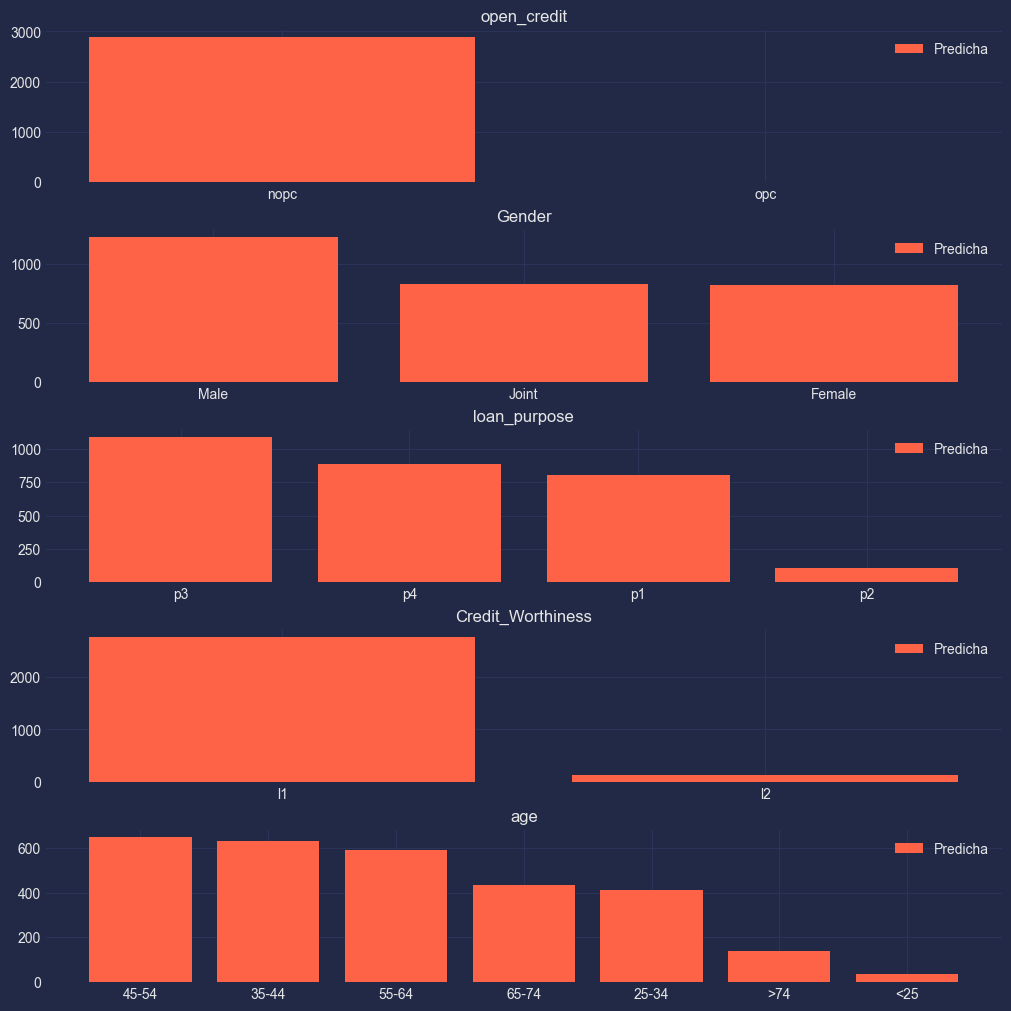

In [645]:
plt.figure()
fig,axs = plt.subplots(5,1,layout="constrained",figsize = (10,10))
for num,i in enumerate(fv):
    axs[num].bar(data[i].value_counts().index,aux[i].value_counts(),color = 'tomato')
    axs[num].set_title(i)
    axs[num].legend(['Predicha'])
plt.show()

In [646]:
precision = conf_mat[0][0] / (conf_mat[0][0] +conf_mat[0][1])
exhaustividad = conf_mat[0][0] / (conf_mat[0][0] +conf_mat[1][0])
f_score = 2/ (1/precision + 1/exhaustividad)
print(f_score)

0.9438775510204082


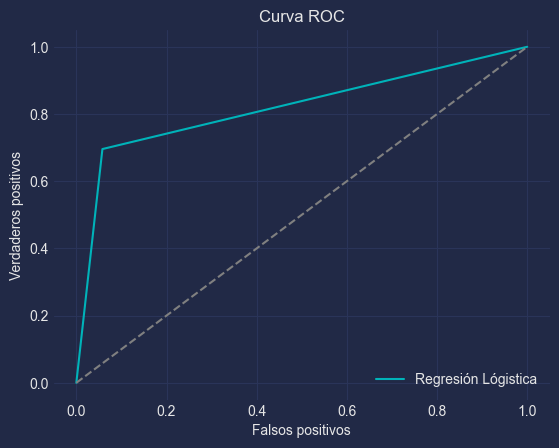

12

In [647]:
fpr,tpr,_ = roc_curve(y_test,y_pred)
plt.plot(fpr,tpr,label = "Regresión Lógistica", color='#00B3B9')
plt.xlabel('Falsos positivos')
plt.ylabel('Verdaderos positivos')
plt.title('Curva ROC')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend(loc=4)
plt.show()
12


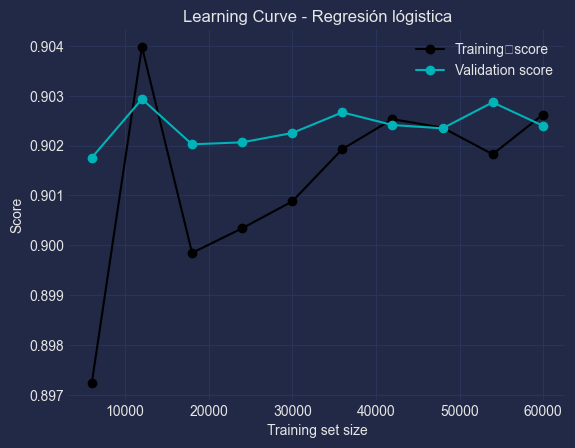

In [648]:

from sklearn.model_selection import learning_curve
train_sizes, train_scores, validation_scores = learning_curve(
estimator = log_reg,
X = X_train,
y = y_train,
train_sizes = np.linspace(0.1, 1.0, 10),
cv = 5,
scoring = 'accuracy'
)

train_mean_tree = np.mean(train_scores, axis=1)
validation_mean_tree = np.mean(validation_scores, axis=1)
plt.figure()
plt.title('Learning Curve - Regresión lógistica')
plt.xlabel('Training set size')


plt.ylabel('Score')
plt.grid(True)
plt.plot(train_sizes, train_mean_tree, 'o-', color="black", label = 'Training␣score')
plt.plot(train_sizes, validation_mean_tree, 'o-', color="#00B3B9", label ='Validation score')
plt.legend(loc = "best")
plt.show()


In [649]:
coef_lof = pd.DataFrame(log_reg.coef_,columns=aux.columns)
coef_lof['intercept'] = log_reg.intercept_
# colorm = sns.light_palette("seagreen", as_cmap=True)
# coef_lof.style.background_gradient(cmap=colorm)

In [654]:
coef_lof

,0,1,Credit_Worthiness,loan_amount,income,Credit_Score,LTV,Gender,loan_purpose,open_credit,Upfront_charges,age,dtir1,intercept
0,-0.000054,0.001982,0.000227,-0.000003,-0.000027,0.000712,0.005935,-0.000468,-0.002181,0.000022,-3.33229,0.001627,0.011103,0.000122
